In [8]:
!pip install altair

In [22]:
import pandas as pd
import gdown
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs, coord_flip

In [2]:
customers_url = "https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE"
products_url = "https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0"
transactions_url = "https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"

In [3]:
gdown.download(customers_url, "Customers.csv", quiet=False)
gdown.download(products_url, "Products.csv", quiet=False)
gdown.download(transactions_url, "Transactions.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE
To: /content/Customers.csv
100%|██████████| 8.54k/8.54k [00:00<00:00, 7.38MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0
To: /content/Products.csv
100%|██████████| 4.25k/4.25k [00:00<00:00, 7.41MB/s]
Downloading...
From: https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF
To: /content/Transactions.csv
100%|██████████| 54.7k/54.7k [00:00<00:00, 3.87MB/s]


'Transactions.csv'

In [4]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [18]:
data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

In [6]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price_x          1000 non-null   float64
 7   CustomerName     1000 non-null   object 
 8   Region           1000 non-null   object 
 9   SignupDate       1000 non-null   object 
 10  ProductName      1000 non-null   object 
 11  Category         1000 non-null   object 
 12  Price_y          1000 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB


In [19]:
#Type casting the columns to avoid future redundencies
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['SignupDate'] = pd.to_datetime(data['SignupDate'])
categorical_columns = ['TransactionID', 'CustomerID', 'ProductID', 'CustomerName', 'Region', 'ProductName', 'Category']
for col in categorical_columns:
    data[col] = data[col].astype('category')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   category      
 1   CustomerID       1000 non-null   category      
 2   ProductID        1000 non-null   category      
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price_x          1000 non-null   float64       
 7   CustomerName     1000 non-null   category      
 8   Region           1000 non-null   category      
 9   SignupDate       1000 non-null   datetime64[ns]
 10  ProductName      1000 non-null   category      
 11  Category         1000 non-null   category      
 12  Price_y          1000 non-null   float64       
dtypes: category(7), datetime64[ns](2), float64(3), int64(1)
memory usage: 124.0 KB


In [10]:
data.isnull().sum()

,0
TransactionID,0
CustomerID,0
ProductID,0
TransactionDate,0
Quantity,0
TotalValue,0
Price_x,0
CustomerName,0
Region,0
SignupDate,0


In [11]:
data.duplicated().sum()

0

In [13]:
# checking for outliers
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")

Quantity: 0 outliers
TotalValue: 0 outliers
Price_x: 0 outliers
Price_y: 0 outliers


## Analysis on custuomer data

Analysisng custuomers based on region

<ipython-input-29-3204a7f10c7d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



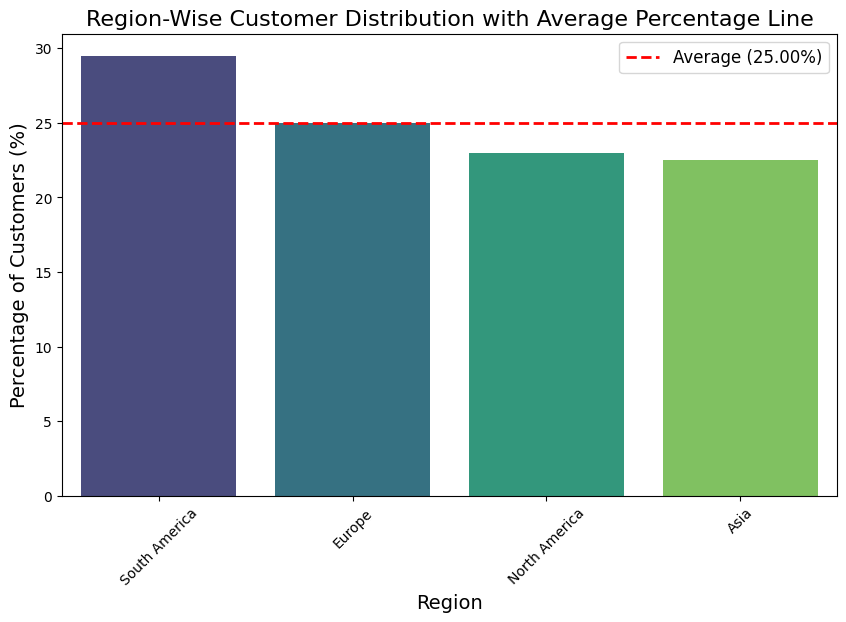

In [29]:
region_distribution = customers['Region'].value_counts()
region_percentage = (region_distribution / region_distribution.sum()) * 100

average_percentage = region_percentage.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=region_percentage.index, y=region_percentage.values, palette='viridis')
plt.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label=f'Average ({average_percentage:.2f}%)')
plt.title('Region-Wise Customer Distribution with Average Percentage Line', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Percentage of Customers (%)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.show()


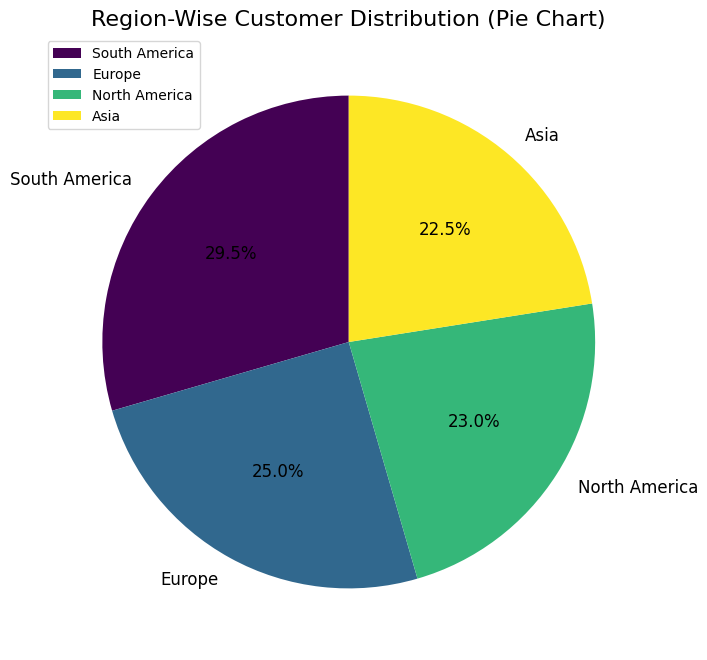

In [24]:
plt.figure(figsize=(8, 8))
region_distribution.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis', legend=True, fontsize=12)
plt.title('Region-Wise Customer Distribution (Pie Chart)', fontsize=16)
plt.ylabel('')
plt.show()

Customer Sign up trends

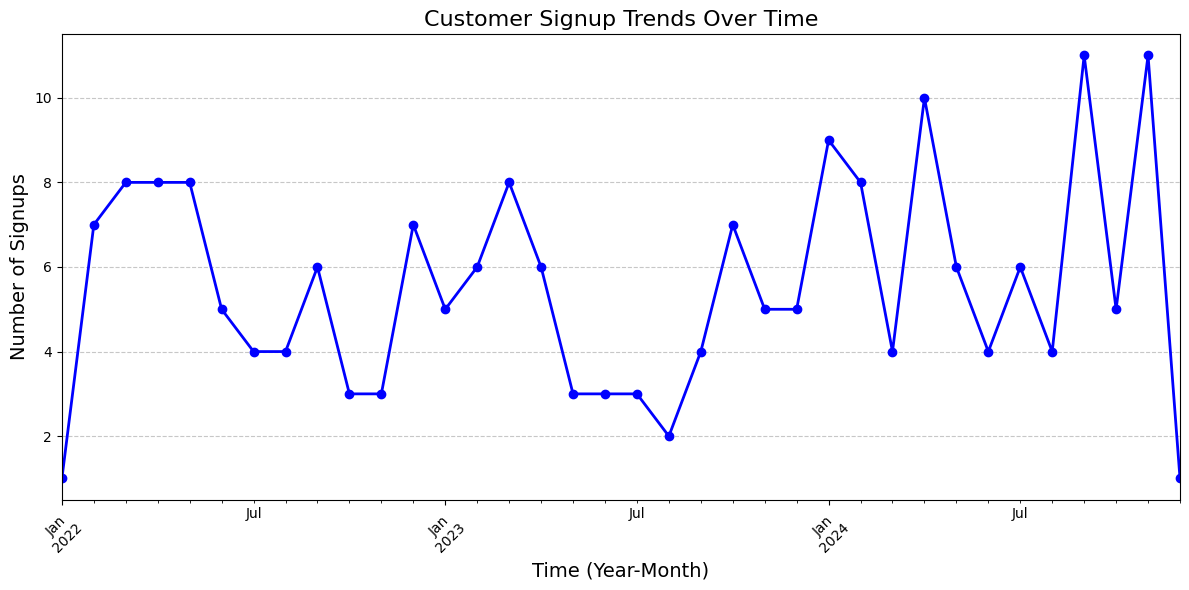

In [30]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

customers['YearMonth'] = customers['SignupDate'].dt.to_period('M')

signup_trends = customers.groupby('YearMonth').size()
plt.figure(figsize=(12, 6))
signup_trends.plot(kind='line', marker='o', color='blue', linewidth=2)
plt.title('Customer Signup Trends Over Time', fontsize=16)
plt.xlabel('Time (Year-Month)', fontsize=14)
plt.ylabel('Number of Signups', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Analysis on products data**

Category-Wise Product Distribution

<ipython-input-32-c3e3be0d155e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



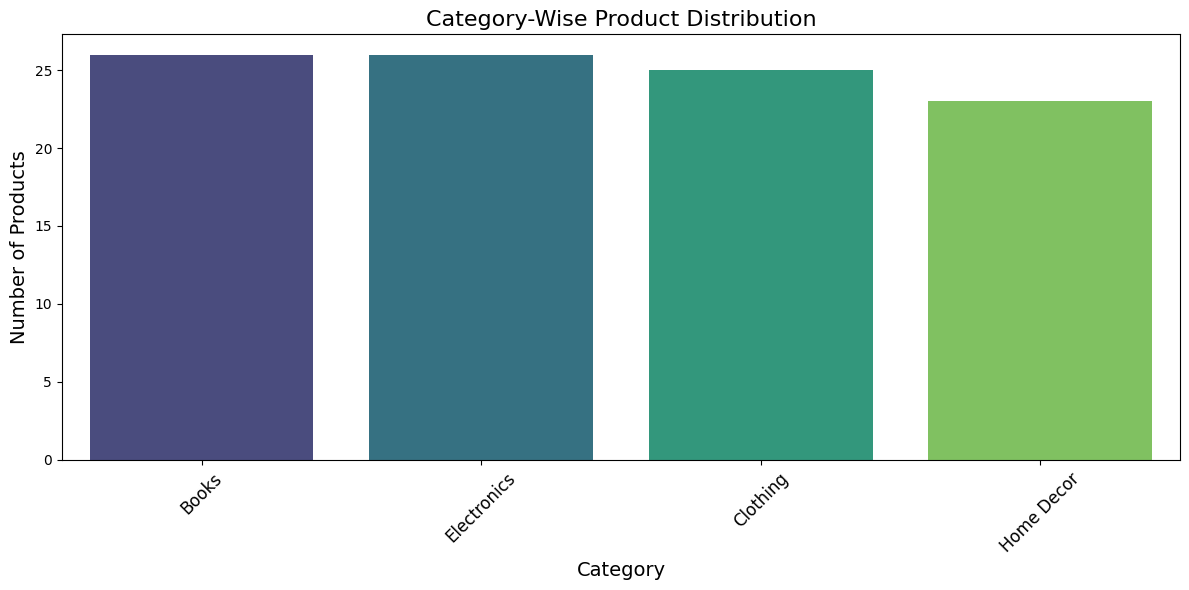

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(data=products, x='Category', palette='viridis', order=products['Category'].value_counts().index)
plt.title('Category-Wise Product Distribution', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Products', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

Top 10 Most Expensive Products

<ipython-input-33-95d92b06c4b4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



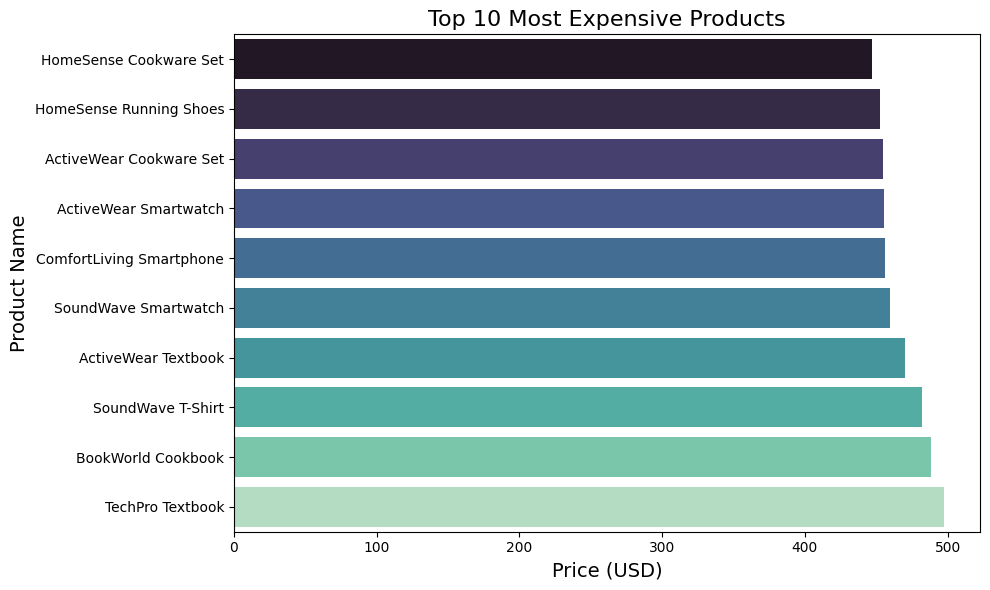

In [33]:
top_10_expensive = products.nlargest(10, 'Price')[['ProductName', 'Price']].sort_values(by='Price', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_expensive, x='Price', y='ProductName', palette='mako')
plt.title('Top 10 Most Expensive Products', fontsize=16)
plt.xlabel('Price (USD)', fontsize=14)
plt.ylabel('Product Name', fontsize=14)
plt.tight_layout()
plt.show()

## Analysis on complete transactional data merged with customers and products data

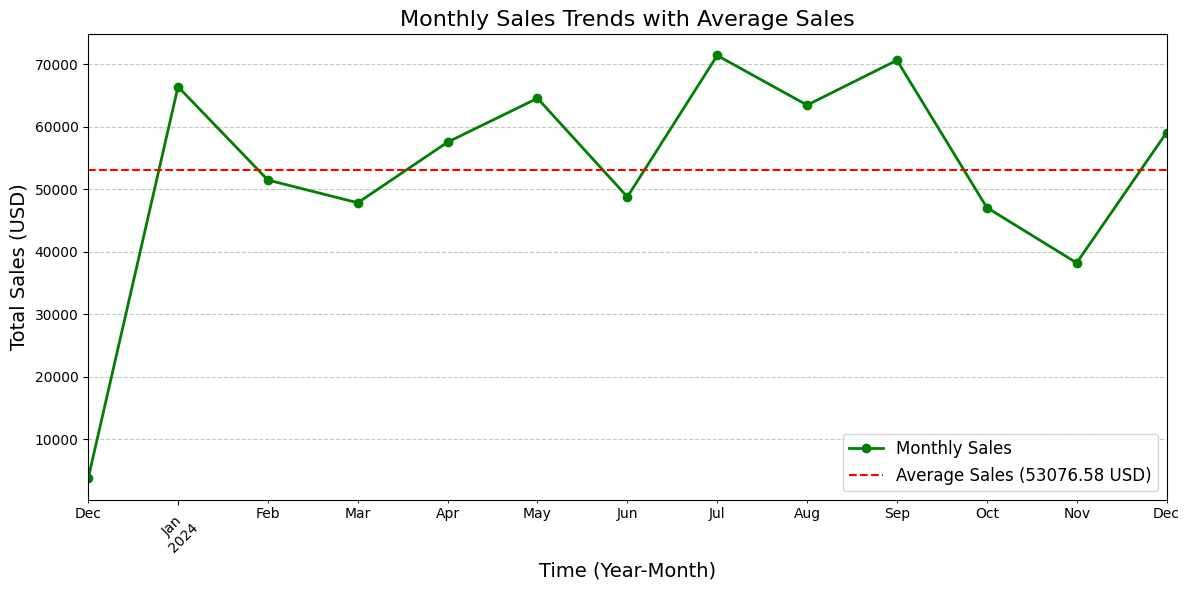

In [36]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['YearMonth'] = transactions['TransactionDate'].dt.to_period('M')
monthly_sales = transactions.groupby('YearMonth')['TotalValue'].sum()

average_sales = monthly_sales.mean()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', color='green', linewidth=2, label='Monthly Sales')

plt.axhline(y=average_sales, color='red', linestyle='--', label=f'Average Sales ({average_sales:.2f} USD)')

plt.title('Monthly Sales Trends with Average Sales', fontsize=16)
plt.xlabel('Time (Year-Month)', fontsize=14)
plt.ylabel('Total Sales (USD)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()


<ipython-input-41-155b2836fd47>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<ipython-input-41-155b2836fd47>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



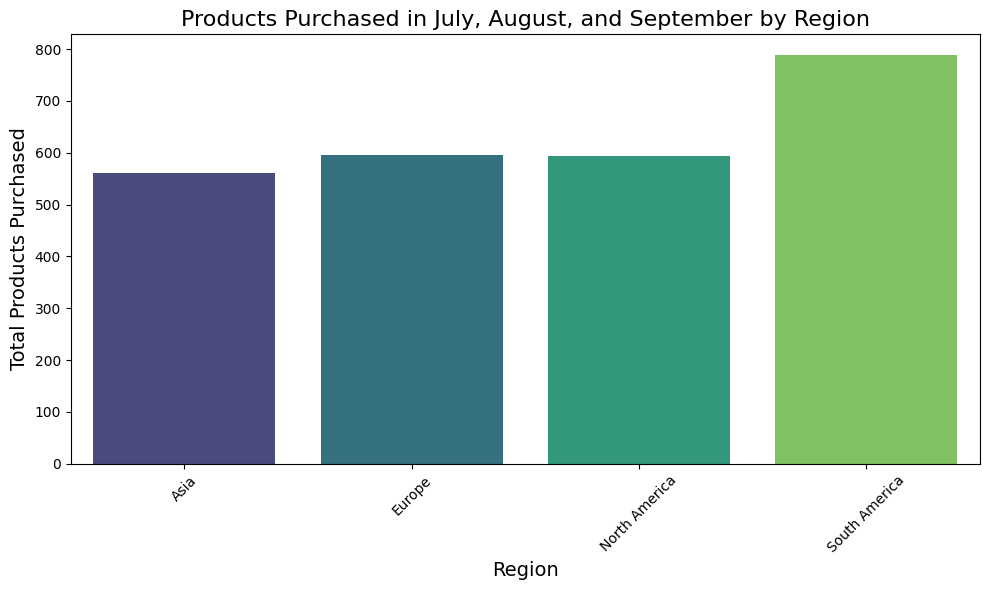

In [41]:

transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

transactions['Month'] = transactions['TransactionDate'].dt.month_name()

filtered_data = data[transactions['Month'].isin(['July', 'August', 'September'])]

products_by_region = data.groupby('Region')['Quantity'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=products_by_region.index, y=products_by_region.values, palette='viridis')

plt.title('Products Purchased in July, August, and September by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Total Products Purchased', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Top 10 product spurchase especially between july-Sept

<ipython-input-80-274b91568e30>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<ipython-input-80-274b91568e30>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



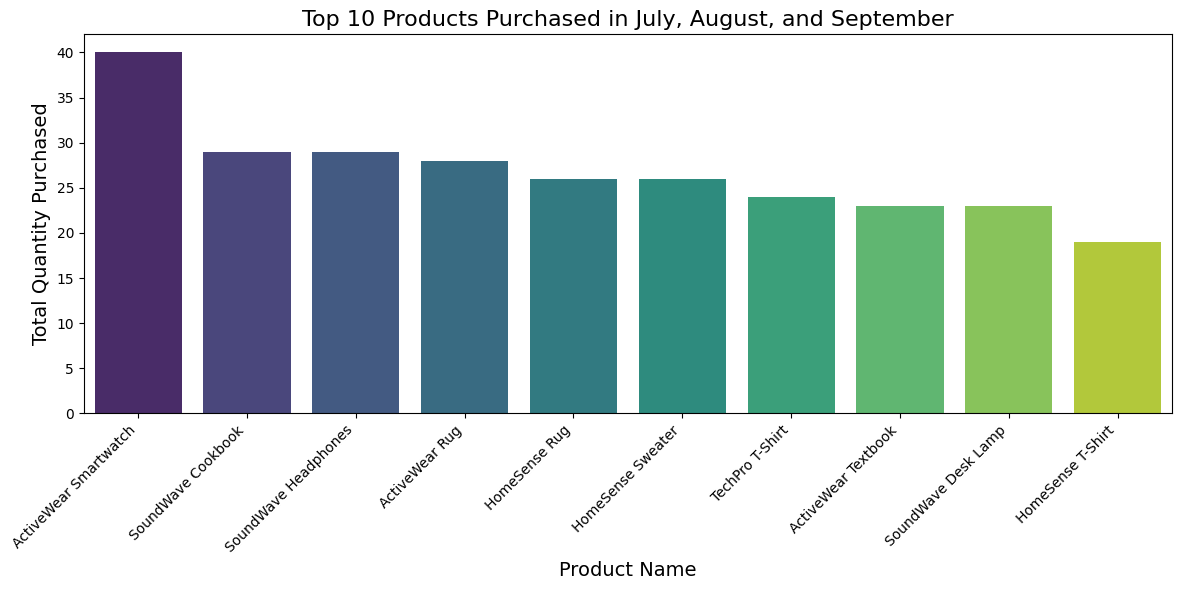

In [80]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

data['Month'] = data['TransactionDate'].dt.month_name()
ppi = products_purchased.index.astype('str')
filtered_data = data[(data['Month'].isin(['July', 'August', 'September'])) & (data['Quantity'] > 0)]
products_purchased = filtered_data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=ppi[:10], y=products_purchased.values[:10], palette='viridis')
plt.title('Top 10 Products Purchased in July, August, and September', fontsize=16)
plt.xlabel('Product Name', fontsize=14)
plt.ylabel('Total Quantity Purchased', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


# To products by Sales Volume

1.   List item
2.   List item



<ipython-input-71-192e31dd67f3>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<ipython-input-71-192e31dd67f3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



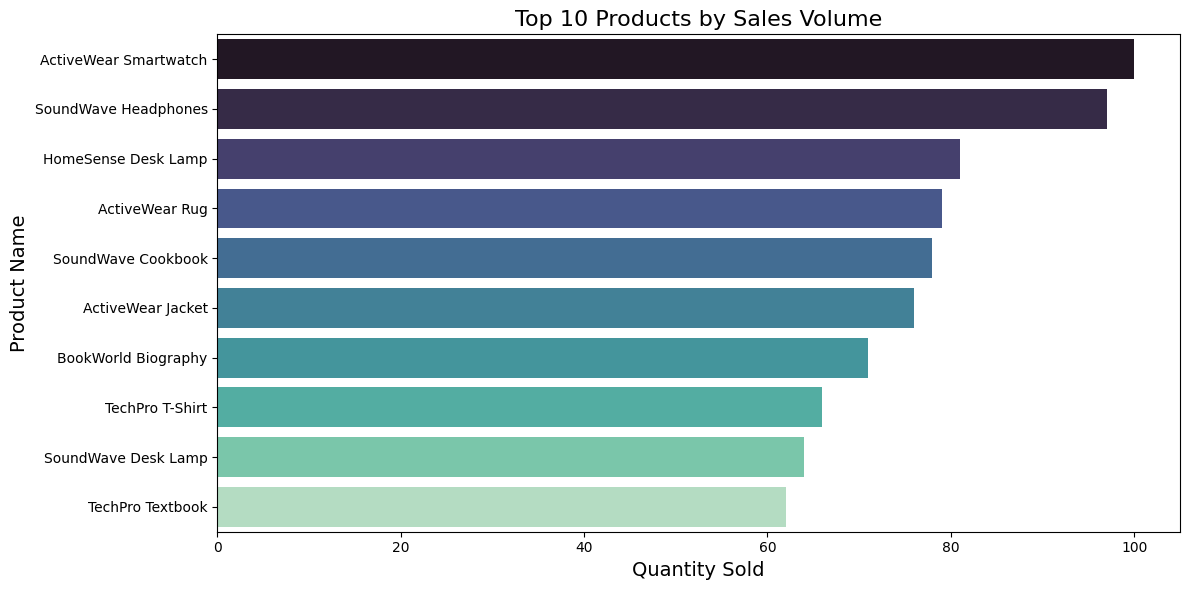

In [71]:
# Top Products by Sales Volume
top_products = data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.index = top_products.index.astype('str')
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='mako')
plt.title('Top 10 Products by Sales Volume', fontsize=16)
plt.xlabel('Quantity Sold', fontsize=14)
plt.ylabel('Product Name', fontsize=14)
plt.tight_layout()
plt.show()

#Region wise sales Distribution by category

<ipython-input-82-72a73bd54195>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


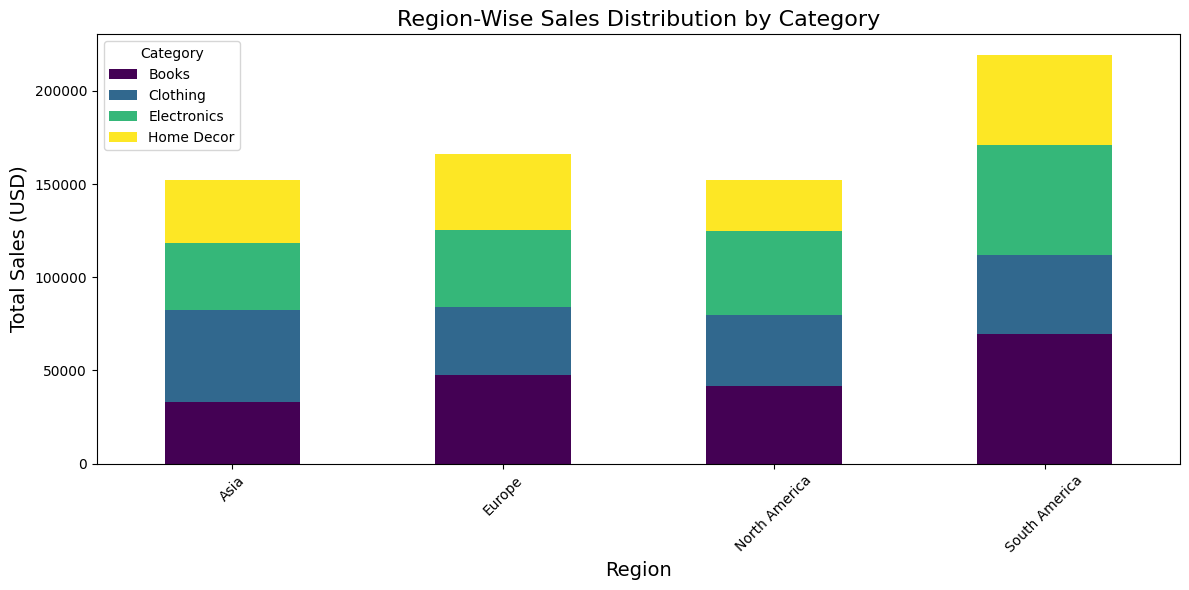

In [82]:
region_category_sales = data.groupby(['Region', 'Category'])['TotalValue'].sum().unstack()

region_category_sales.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Region-Wise Sales Distribution by Category', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Total Sales (USD)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Customer Retention Analysis

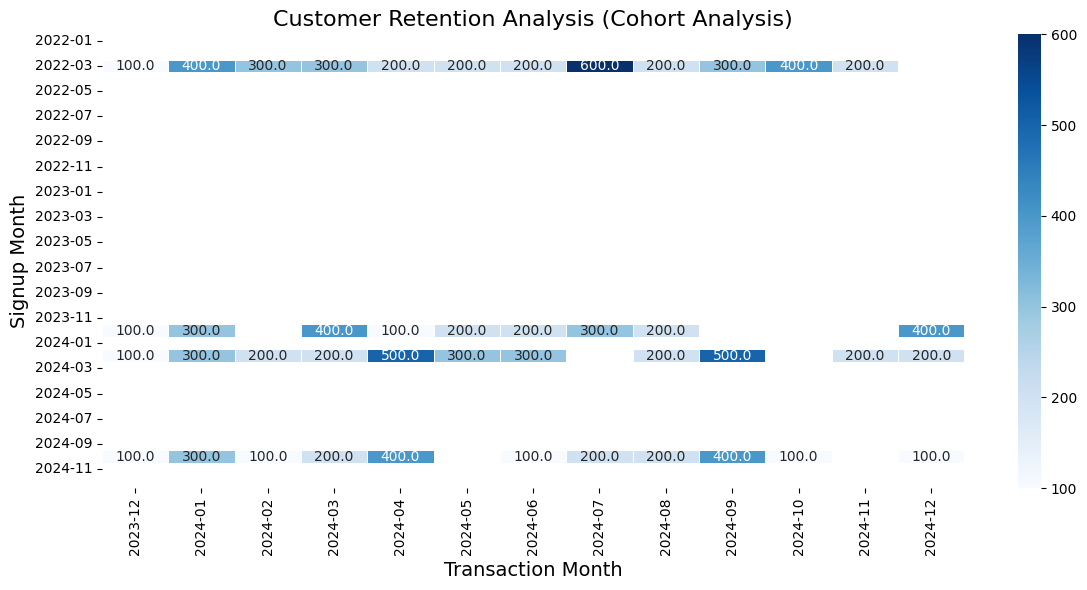

In [86]:
data['SignupMonth'] = data['SignupDate'].dt.to_period('M')
data['TransactionMonth'] = data['TransactionDate'].dt.to_period('M')

cohort_data = data.groupby(['SignupMonth', 'TransactionMonth']).agg(
    customers=('CustomerID', 'nunique')).reset_index()

cohort_pivot = cohort_data.pivot_table(index='SignupMonth', columns='TransactionMonth', values='customers')

cohort_retention = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0) * 100

plt.figure(figsize=(12, 6))
sns.heatmap(cohort_retention, annot=True, fmt='.1f', cmap='Blues', cbar=True, linewidths=0.5)
plt.title('Customer Retention Analysis (Cohort Analysis)', fontsize=16)
plt.xlabel('Transaction Month', fontsize=14)
plt.ylabel('Signup Month', fontsize=14)
plt.tight_layout()
plt.show()


# Top 10 Custuomers by Spending

<ipython-input-89-79cee2969b95>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<ipython-input-89-79cee2969b95>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



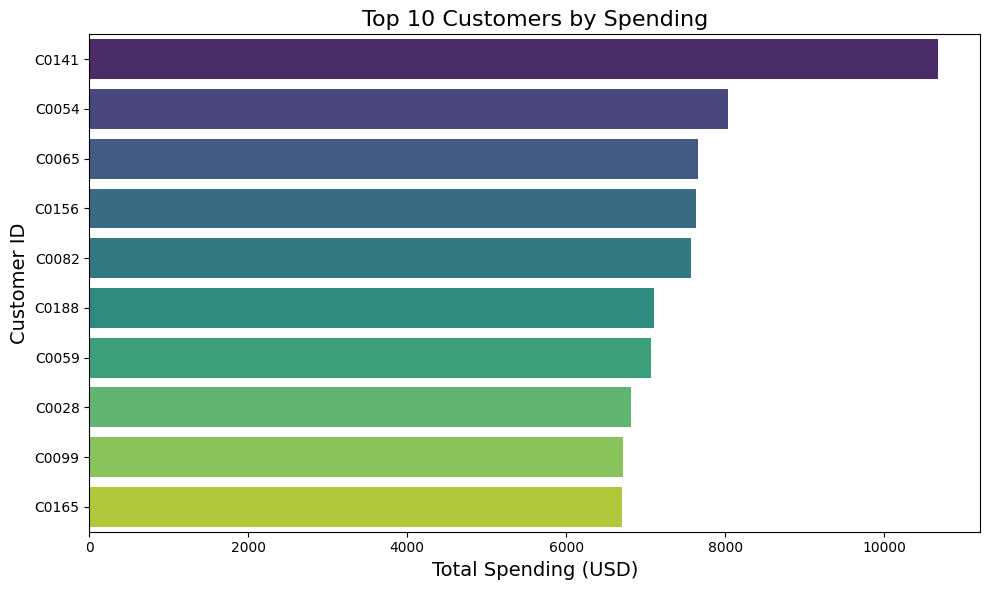

In [89]:
top_customers = data.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum')).sort_values('total_spending', ascending=False)

# Select top 10 customers based on total spending
top_10_customers = top_customers.head(10)
top_10 = top_10_customers.index.astype('str')
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_customers['total_spending'], y=top_10[:10], palette='viridis', orient='h')

# Adding labels and titles
plt.title('Top 10 Customers by Spending', fontsize=16)
plt.xlabel('Total Spending (USD)', fontsize=14)
plt.ylabel('Customer ID', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()